## PART 1 : Data Engineer

### 1. Library

In [1]:
!pip install beautifulsoup4
!pip install scikit-learn

import os
import requests
from bs4 import BeautifulSoup
import urllib.parse
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
import shutil
from sklearn.model_selection import train_test_split

### 2. Data Preparation

In [2]:
def fetch_image(img_url, output_path, index, query):
    try:
        img_data = requests.get(img_url).content
        with open(os.path.join(output_path, f"{query.replace(' ', '_')}_{index}.jpg"), 'wb') as handler:
            handler.write(img_data)
        print(f"Downloaded {query.replace(' ', '_')}_{index}.jpg")
    except Exception as e:
        print(f"Could not download image {index}: {e}")

def download_images(query, num_images, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    headers = {"User-Agent": "Mozilla/5.0"}
    query_encoded = urllib.parse.quote(query)
    downloaded = 0
    page = 0

    keywords = ['chart', 'graph', 'map', 'maps', 'dog', 'location', 'locations', 'genotypes', 'statistics', 'cartoon']
    capital_keywords = [keyword.capitalize() for keyword in keywords]
    all_keywords = keywords + capital_keywords

    with ThreadPoolExecutor(max_workers=10) as executor:
        future_to_img = {}

        while downloaded < num_images:
            search_url = f"https://www.google.com/search?q={query_encoded}&tbm=isch&start={page*20}"
            response = requests.get(search_url, headers=headers)
            soup = BeautifulSoup(response.text, 'html.parser')
            img_tags = soup.find_all('img')[1:]

            if not img_tags:
                break

            for i, img in enumerate(img_tags):
                if downloaded >= num_images:
                    break
                try:
                    img_url = img.get('src') or img.get('data-src')
                    alt_text = img.get('alt', '').lower()

                    if not img_url or not img_url.startswith('http'):
                        continue

                    # Additional filtering to avoid downloading irrelevant images
                    if any(keyword in alt_text for keyword in all_keywords):
                        continue
                    if any(keyword in img_url for keyword in all_keywords):
                        continue

                    future = executor.submit(fetch_image, img_url, output_dir, downloaded, query)
                    future_to_img[future] = downloaded
                    downloaded += 1
                except Exception as e:
                    print(f"Could not process image {downloaded}: {e}")

            page += 1
            time.sleep(1)

        for future in as_completed(future_to_img):
            future.result()

# Start the crawling process with error handling
def main():
    queries = [
        ("Parrot", 1000, "data/african_grey_parrot"),
        ("Flamingo", 1000, "data/flamingo"),
        ("Eagle", 1000, "data/bald_eagle"),
        ("Owl", 1000, "data/snowy_owl"),
        ("Peacock", 1000, "data/peacock"),
        ("Penguin", 1000, "data/penguin")
    ]

    for query, num_images, output_dir in queries:
        print(f"Starting download for {query}...")
        download_images(query, num_images, output_dir)
        time.sleep(1)

if __name__ == "__main__":
    main()


Starting download for Parrot...
Downloaded Parrot_0.jpg
Downloaded Parrot_1.jpg
Downloaded Parrot_2.jpg
Downloaded Parrot_6.jpg
Downloaded Parrot_5.jpg
Downloaded Parrot_8.jpg
Downloaded Parrot_9.jpg
Downloaded Parrot_7.jpg
Downloaded Parrot_4.jpg
Downloaded Parrot_3.jpg
Downloaded Parrot_11.jpg
Downloaded Parrot_14.jpg
Downloaded Parrot_16.jpg
Downloaded Parrot_17.jpg
Downloaded Parrot_12.jpg
Downloaded Parrot_10.jpg
Downloaded Parrot_18.jpg
Downloaded Parrot_13.jpg
Downloaded Parrot_15.jpg
Downloaded Parrot_19.jpg
Downloaded Parrot_25.jpg
Downloaded Parrot_27.jpg
Downloaded Parrot_24.jpg
Downloaded Parrot_26.jpg
Downloaded Parrot_21.jpg
Downloaded Parrot_23.jpg
Downloaded Parrot_20.jpg
Downloaded Parrot_28.jpg
Downloaded Parrot_22.jpg
Downloaded Parrot_31.jpg
Downloaded Parrot_33.jpg
Downloaded Parrot_30.jpg
Downloaded Parrot_36.jpg
Downloaded Parrot_38.jpg
Downloaded Parrot_32.jpg
Downloaded Parrot_34.jpg
Downloaded Parrot_35.jpg
Downloaded Parrot_39.jpg
Downloaded Parrot_37.jpg
Dow

## 3. Graph Bar for Data

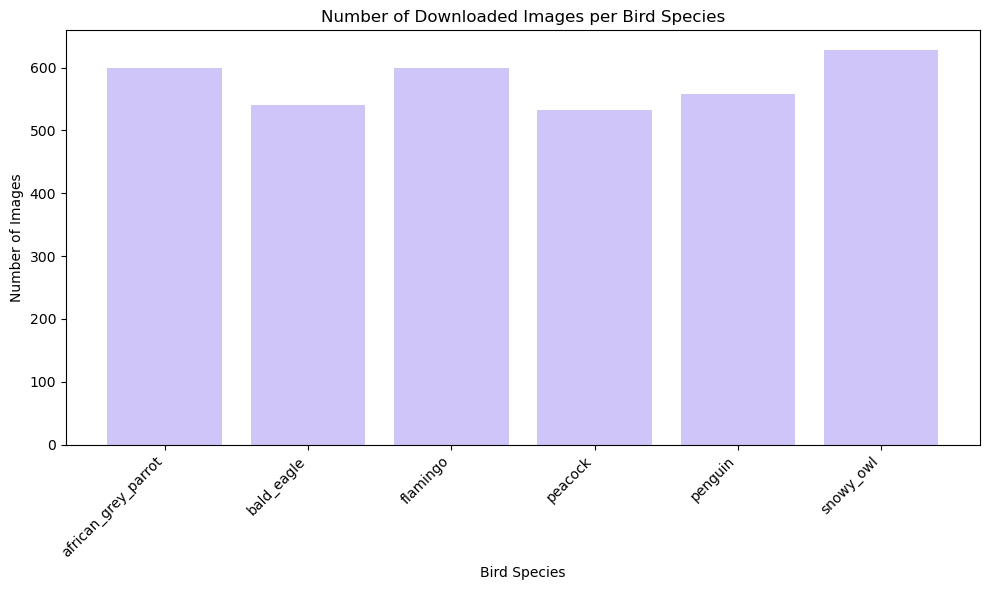

In [3]:
!pip install matplotlib
import os
import matplotlib.pyplot as plt

directories = [
    "data/african_grey_parrot",
    "data/flamingo",
    "data/bald_eagle",
    "data/snowy_owl",
    "data/peacock",
    "data/penguin"
]

breed_counts = {}

for directory in directories:
    breed_name = os.path.basename(directory)  # Extract the breed name from the directory path
    if os.path.exists(directory):
        num_files = len(os.listdir(directory))
        breed_counts[breed_name] = num_files

sorted_counts = dict(sorted(breed_counts.items()))

plt.figure(figsize=(10, 6))
plt.bar(sorted_counts.keys(), sorted_counts.values(), color='#D0C5F9')
plt.xlabel('Bird Species')
plt.ylabel('Number of Images')
plt.title('Number of Downloaded Images per Bird Species')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


## 4. Split Dataset

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

def create_split_directories(base_dir, categories, splits):
    for split in splits:
        for category in categories:
            split_dir = os.path.join(base_dir, split, category)
            os.makedirs(split_dir, exist_ok=True)

def split_data(base_dir, categories, split_ratios):
    train_ratio, val_ratio, test_ratio = split_ratios
    splits = ['train', 'validation', 'test']
    create_split_directories(base_dir, categories, splits)

    for category in categories:
        category_dir = os.path.join(base_dir, category)
        images = [img for img in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, img))]
        train_and_val, test = train_test_split(images, test_size=test_ratio, random_state=42)
        train, val = train_test_split(train_and_val, test_size=val_ratio/(train_ratio + val_ratio), random_state=42)

        for split, split_images in zip(splits, [train, val, test]):
            split_dir = os.path.join(base_dir, split, category)
            for image in split_images:
                shutil.move(os.path.join(category_dir, image), os.path.join(split_dir, image))

# Define base directory and categories 
base_dir = "data"
categories = ["african_grey_parrot", "flamingo", "bald_eagle", "snowy_owl", "peacock", "penguin"]

# Define split ratios: 70% training, 15% validation, 15% testing
split_ratios = (0.7, 0.15, 0.15)

# Perform the split
split_data(base_dir, categories, split_ratios)


In [5]:
# Count the number of images in each split
def count_images_in_splits(base_dir, categories):
    splits = ['train', 'validation', 'test']

    # Initialize a dictionary to keep track of image counts for each split
    split_counts = {split: {category: 0 for category in categories} for split in splits}

    # Count the images in each split
    for split in splits:
        for category in categories:
            split_dir = os.path.join(base_dir, split, category)
            if os.path.exists(split_dir):
                # Count the number of images in each split directory
                split_counts[split][category] = len([img for img in os.listdir(split_dir) if os.path.isfile(os.path.join(split_dir, img))])

    # Print the counts for each split and category
    for split in splits:
        print(f"\n{split.capitalize()} Split:")
        for category in categories:
            print(f"{category}: {split_counts[split][category]} images")

# Define base directory and categories
base_dir = "data"
categories = ["african_grey_parrot", "flamingo", "bald_eagle", "snowy_owl", "peacock", "penguin"]

# Count the images in each split
count_images_in_splits(base_dir, categories)



Train Split:
african_grey_parrot: 626 images
flamingo: 612 images
bald_eagle: 541 images
snowy_owl: 638 images
peacock: 564 images
penguin: 585 images

Validation Split:
african_grey_parrot: 440 images
flamingo: 376 images
bald_eagle: 371 images
snowy_owl: 463 images
peacock: 386 images
penguin: 477 images

Test Split:
african_grey_parrot: 302 images
flamingo: 241 images
bald_eagle: 251 images
snowy_owl: 310 images
peacock: 256 images
penguin: 295 images


In [6]:
!pip install tensorflow keras matplotlib scikit-learn

## PART 2 : Data Scientist

## 5. Import Libraries

In [7]:
!pip install tensorflow

In [8]:
!pip install tensorflow keras matplotlib scikit-learn

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet121, MobileNetV3Small
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import average_precision_score, classification_report
import numpy as np
import time
import os

## 6. Dataset Paths and Parameters

In [9]:
# Define paths
base_dir = 'data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Image size and batch size
img_size = (224, 224)
batch_size = 32
num_classes = 6  


## 7. Prepare Image Generators

In [10]:
def get_data_generators(preprocess_fn):
    train_gen = ImageDataGenerator(preprocessing_function=preprocess_fn)
    val_gen = ImageDataGenerator(preprocessing_function=preprocess_fn)
    test_gen = ImageDataGenerator(preprocessing_function=preprocess_fn)

    train_data = train_gen.flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
    val_data = val_gen.flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical')
    test_data = test_gen.flow_from_directory(test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

    return train_data, val_data, test_data

## 8. Build Model Function

In [11]:
def build_model(base_model_class, preprocess_fn, input_shape=(224, 224, 3), num_classes=6):
    base_model = base_model_class(include_top=False, input_shape=input_shape, weights='imagenet')
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

## 9. Train and Evaluate Models

In [12]:
def train_and_evaluate(model_name, model_fn, preprocess_fn):
    print(f"\nTraining {model_name}...")
    train_data, val_data, test_data = get_data_generators(preprocess_fn)
    model = model_fn()
    
    start_time = time.time()
    history = model.fit(train_data, validation_data=val_data, epochs=50)
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Evaluate on test set
    y_true = test_data.classes
    y_pred_proba = model.predict(test_data)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Accuracy
    acc = np.mean(y_pred == y_true)

    # Mean Average Precision
    y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes)
    mAP = average_precision_score(y_true_one_hot, y_pred_proba, average='macro')

    print(f"{model_name} Accuracy: {acc:.4f}")
    print(f"{model_name} mAP: {mAP:.4f}")
    print(f"{model_name} Training Time: {elapsed_time:.2f} seconds")

    return model, history, acc, mAP, elapsed_time

In [14]:
import os
import pickle
from tensorflow.keras.models import load_model

# -------- ResNet50 --------
resnet_model_path = 'resnet50_model.h5'
resnet_history_path = 'resnet50_history.pkl'

if not os.path.exists(resnet_model_path):
    resnet_model_fn = lambda: build_model(ResNet50, resnet_preprocess)
    resnet_model, resnet_history, resnet_acc, resnet_map, resnet_time = train_and_evaluate("ResNet50", resnet_model_fn, resnet_preprocess)
    resnet_model.save(resnet_model_path)
    with open(resnet_history_path, 'wb') as f:
        pickle.dump(resnet_history.history, f)
else:
    print("ResNet50 model already exists. Loading...")
    resnet_model = load_model(resnet_model_path)
    with open(resnet_history_path, 'rb') as f:
        resnet_history = pickle.load(f)

# -------- DenseNet121 --------
densenet_model_path = 'densenet121_model.h5'
densenet_history_path = 'densenet121_history.pkl'

if not os.path.exists(densenet_model_path):
    densenet_model_fn = lambda: build_model(DenseNet121, densenet_preprocess)
    densenet_model, densenet_history, densenet_acc, densenet_map, densenet_time = train_and_evaluate("DenseNet121", densenet_model_fn, densenet_preprocess)
    densenet_model.save(densenet_model_path)
    with open(densenet_history_path, 'wb') as f:
        pickle.dump(densenet_history.history, f)
else:
    print("DenseNet121 model already exists. Loading...")
    densenet_model = load_model(densenet_model_path)
    with open(densenet_history_path, 'rb') as f:
        densenet_history = pickle.load(f)

# -------- MobileNetV3Small --------
mobilenet_model_path = 'mobilenetv3_model.h5'
mobilenet_history_path = 'mobilenetv3_history.pkl'

if not os.path.exists(mobilenet_model_path):
    mobilenet_model_fn = lambda: build_model(MobileNetV3Small, mobilenet_preprocess)
    mobilenet_model, mobilenet_history, mobilenet_acc, mobilenet_map, mobilenet_time = train_and_evaluate("MobileNetV3Small", mobilenet_model_fn, mobilenet_preprocess)
    mobilenet_model.save(mobilenet_model_path)
    with open(mobilenet_history_path, 'wb') as f:
        pickle.dump(mobilenet_history.history, f)
else:
    print("MobileNetV3 model already exists. Loading...")
    mobilenet_model = load_model(mobilenet_model_path)
    with open(mobilenet_history_path, 'rb') as f:
        mobilenet_history = pickle.load(f)



Training ResNet50...
Found 3566 images belonging to 6 classes.
Found 2513 images belonging to 6 classes.
Found 1655 images belonging to 6 classes.
Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 467s 4s/step - accuracy: 0.7540 - loss: 0.7184 - val_accuracy: 0.9674 - val_loss: 0.0940
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 423s 4s/step - accuracy: 0.9848 - loss: 0.0494 - val_accuracy: 0.9777 - val_loss: 0.0689
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 423s 4s/step - accuracy: 0.9988 - loss: 0.0124 - val_accuracy: 0.9761 - val_loss: 0.0725
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 449s 4s/step - accuracy: 0.9923 - loss: 0.0218 - val_accuracy: 0.9646 - val_loss: 0.0996
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 437s 4s/step - accuracy: 0.9969 - loss: 0.0144 - val_accuracy: 0.9761 - val_loss: 0.0905
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 436s 4s/step - accuracy: 0.9984 - loss: 0.0087 - val_accuracy: 0.9733 - val_loss: 0.0898
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 469s 4s/step - accuracy: 0.9963 - loss

ResNet50 Accuracy: 0.9378
ResNet50 mAP: 0.9875
ResNet50 Training Time: 22272.78 seconds

Training DenseNet121...
Found 3566 images belonging to 6 classes.
Found 2513 images belonging to 6 classes.
Found 1655 images belonging to 6 classes.
Epoch 1/50


D:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


112/112 ━━━━━━━━━━━━━━━━━━━━ 535s 4s/step - accuracy: 0.6752 - loss: 0.9093 - val_accuracy: 0.9682 - val_loss: 0.0986
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 477s 4s/step - accuracy: 0.9818 - loss: 0.0680 - val_accuracy: 0.9825 - val_loss: 0.0611
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 483s 4s/step - accuracy: 0.9956 - loss: 0.0291 - val_accuracy: 0.9833 - val_loss: 0.0484
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 478s 4s/step - accuracy: 0.9959 - loss: 0.0156 - val_accuracy: 0.9853 - val_loss: 0.0495
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 479s 4s/step - accuracy: 0.9986 - loss: 0.0110 - val_accuracy: 0.9841 - val_loss: 0.0514
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 477s 4s/step - accuracy: 0.9997 - loss: 0.0042 - val_accuracy: 0.9889 - val_loss: 0.0455
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 477s 4s/step - accuracy: 0.9985 - loss: 0.0075 - val_accuracy: 0.9817 - val_loss: 0.0622
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 481s 4s/step - accuracy: 0.9988 - loss: 0.0066 - val_accuracy: 0.985

DenseNet121 Accuracy: 0.9595
DenseNet121 mAP: 0.9933
DenseNet121 Training Time: 26159.53 seconds

Training MobileNetV3Small...
Found 3566 images belonging to 6 classes.
Found 2513 images belonging to 6 classes.
Found 1655 images belonging to 6 classes.
Epoch 1/50


D:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


112/112 ━━━━━━━━━━━━━━━━━━━━ 56s 374ms/step - accuracy: 0.3766 - loss: 1.7029 - val_accuracy: 0.8170 - val_loss: 0.6311
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 40s 357ms/step - accuracy: 0.8278 - loss: 0.5656 - val_accuracy: 0.8993 - val_loss: 0.3480
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 39s 352ms/step - accuracy: 0.8977 - loss: 0.3220 - val_accuracy: 0.9204 - val_loss: 0.2771
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 40s 355ms/step - accuracy: 0.9515 - loss: 0.1746 - val_accuracy: 0.9431 - val_loss: 0.2250
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 40s 356ms/step - accuracy: 0.9628 - loss: 0.1271 - val_accuracy: 0.9526 - val_loss: 0.1809
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 40s 356ms/step - accuracy: 0.9678 - loss: 0.1095 - val_accuracy: 0.9586 - val_loss: 0.1687
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 39s 353ms/step - accuracy: 0.9793 - loss: 0.0733 - val_accuracy: 0.9646 - val_loss: 0.1408
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 40s 358ms/step - accuracy: 0.9887 - loss: 0.0487 - val

MobileNetV3Small Accuracy: 0.9722
MobileNetV3Small mAP: 0.9944
MobileNetV3Small Training Time: 2018.95 seconds


## 10. Plot Training Accuracy & Loss for Each Model

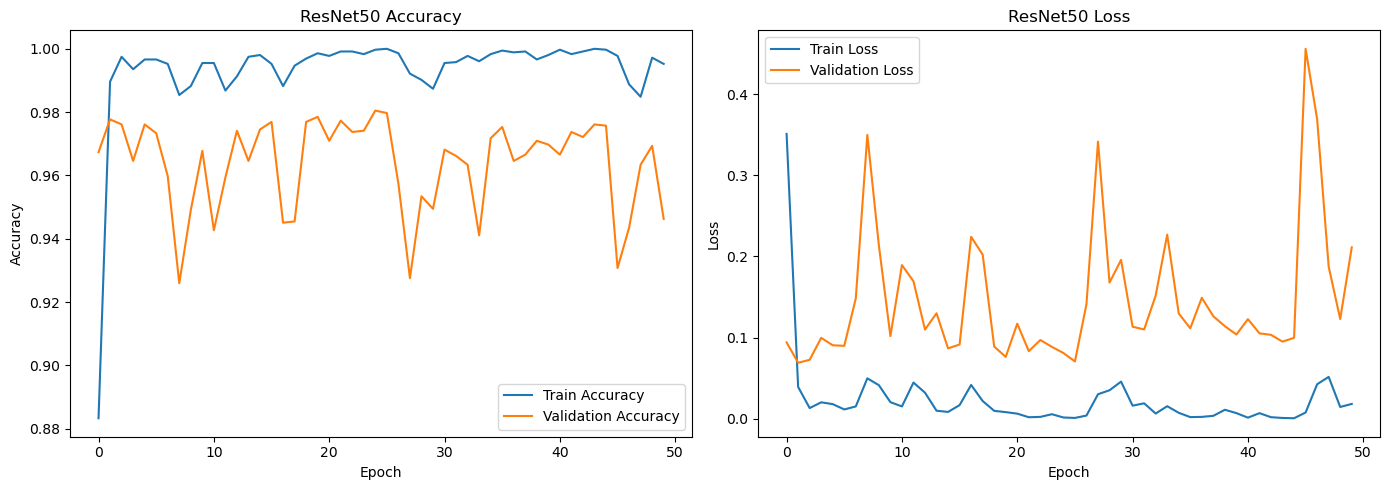

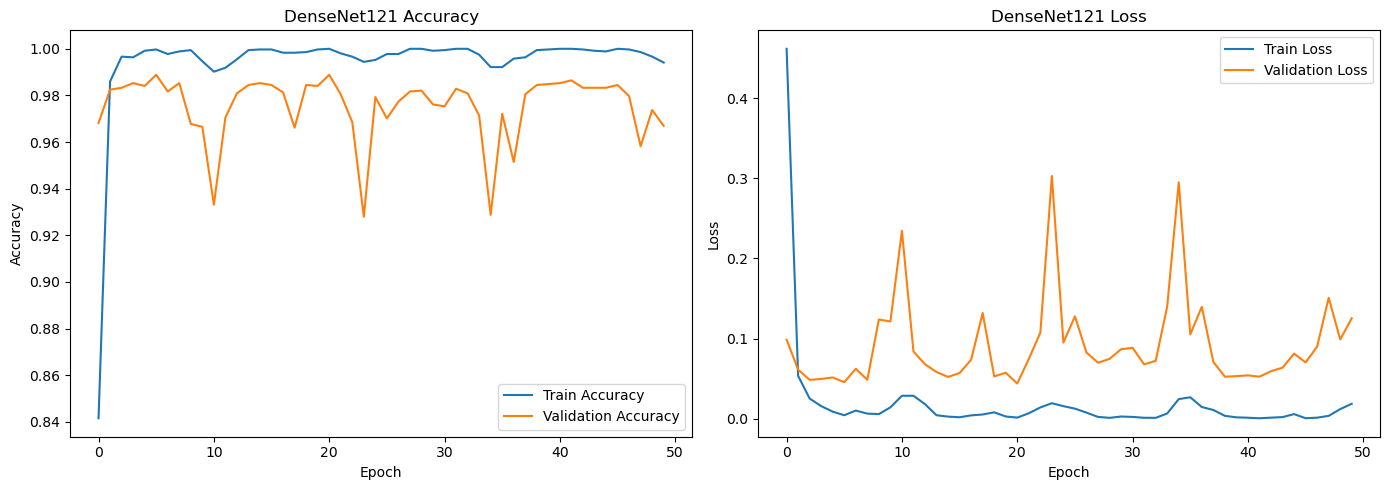

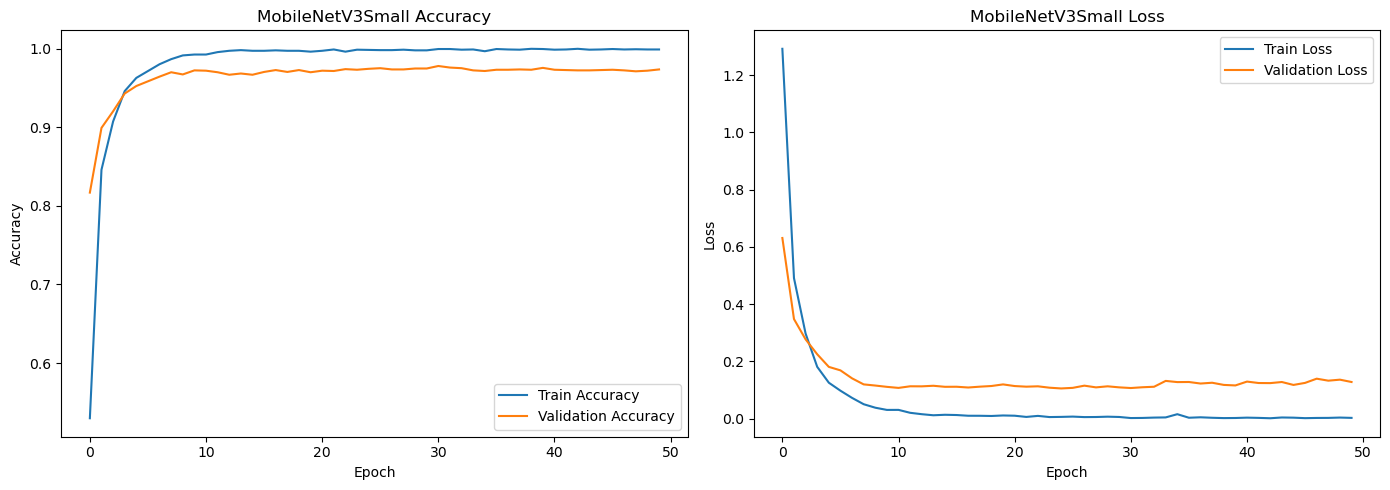

In [15]:
import matplotlib.pyplot as plt

def plot_training_curves(history_data, model_name):
    if isinstance(history_data, dict):  # loaded from pickle
        acc = history_data['accuracy']
        val_acc = history_data['val_accuracy']
        loss = history_data['loss']
        val_loss = history_data['val_loss']
    else:  # Keras History object
        acc = history_data.history['accuracy']
        val_acc = history_data.history['val_accuracy']
        loss = history_data.history['loss']
        val_loss = history_data.history['val_loss']

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot all 3
plot_training_curves(resnet_history, "ResNet50")
plot_training_curves(densenet_history, "DenseNet121")
plot_training_curves(mobilenet_history, "MobileNetV3Small")

## 11. Summary Table of All Models

In [23]:
import pandas as pd

summary = {
    'Model': ['ResNet50', 'DenseNet121', 'MobileNetV3Small'],
    'Accuracy': [resnet_acc, densenet_acc, mobilenet_acc],
    'mAP': [resnet_map, densenet_map, mobilenet_map],
    'Training Time (s)': [resnet_time, densenet_time, mobilenet_time]
}

df_summary = pd.DataFrame(summary)
print(df_summary)

              Model  Accuracy       mAP  Training Time (s)
0          ResNet50  0.937764  0.987472       22272.782253
1       DenseNet121  0.959517  0.993256       26159.534108
2  MobileNetV3Small  0.972205  0.994405        2018.952417


## PART 3 : DATA ANALYST

## 12. Class and Label Distribution

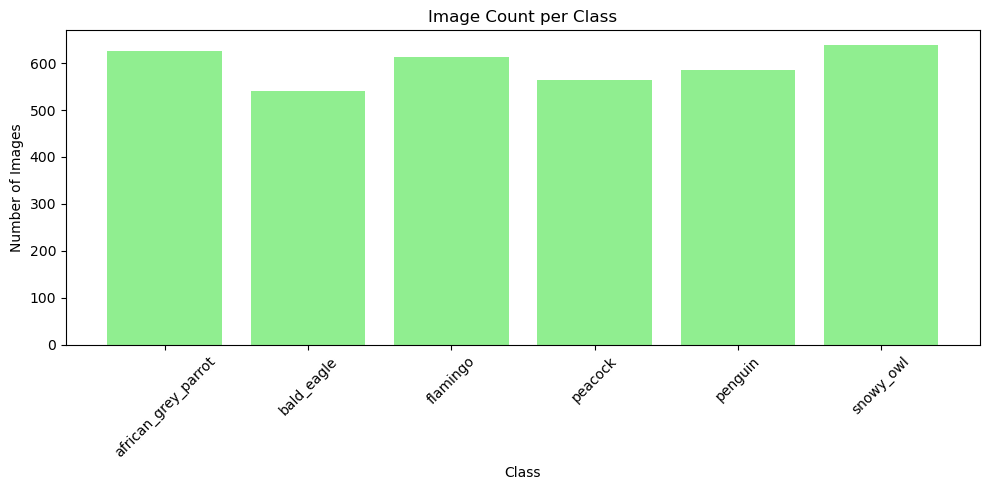

In [24]:
import os
import matplotlib.pyplot as plt

def plot_class_distribution(base_dir):
    class_counts = {}
    for class_name in os.listdir(base_dir):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    
    plt.figure(figsize=(10, 5))
    plt.bar(class_counts.keys(), class_counts.values(), color='lightgreen')
    plt.title('Image Count per Class')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Run this for any split, for example:
plot_class_distribution('data/train')

## 13. Training Performance Curves

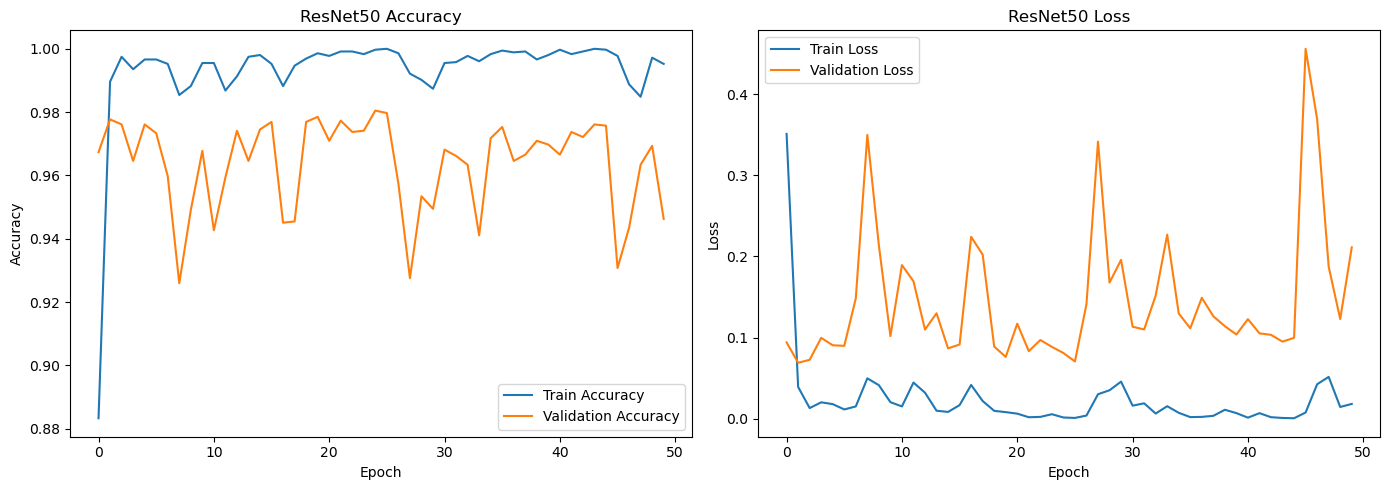

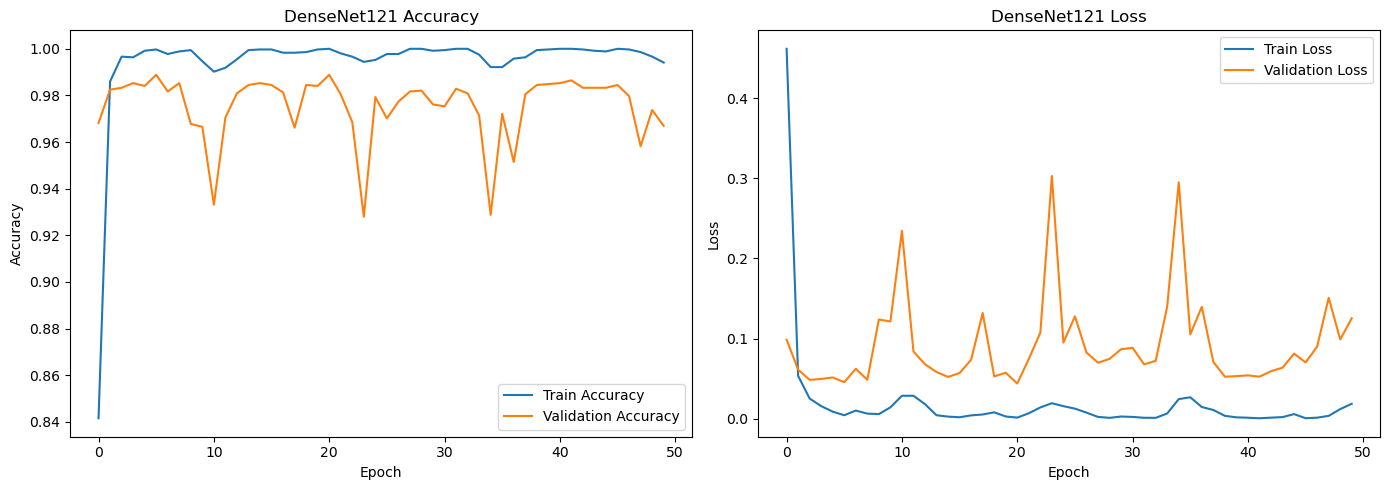

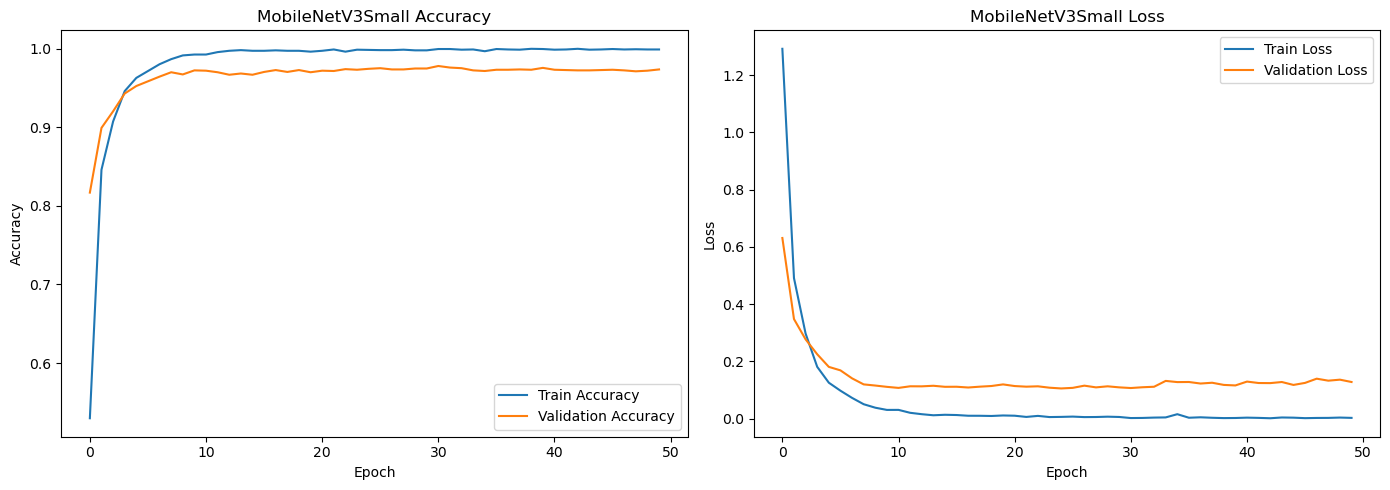

In [25]:
# Use plot_training_curves() to visualize accuracy/loss
plot_training_curves(resnet_history, "ResNet50")
plot_training_curves(densenet_history, "DenseNet121")
plot_training_curves(mobilenet_history, "MobileNetV3Small")

## 14. Confusion Matrix & Classification Report

Found 1655 images belonging to 6 classes.


D:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 38s 736ms/step


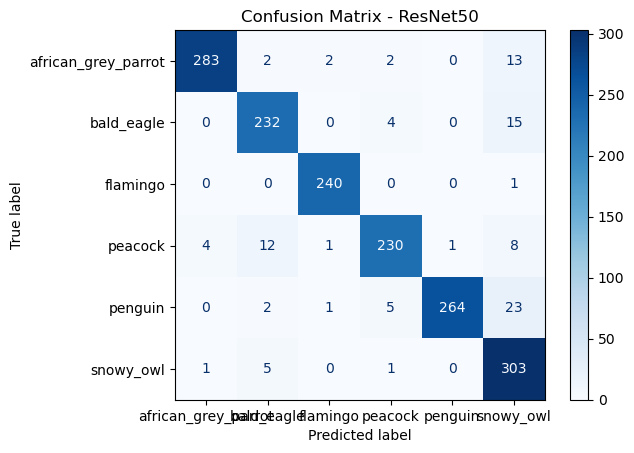


Classification Report - ResNet50
                     precision    recall  f1-score   support

african_grey_parrot       0.98      0.94      0.96       302
         bald_eagle       0.92      0.92      0.92       251
           flamingo       0.98      1.00      0.99       241
            peacock       0.95      0.90      0.92       256
            penguin       1.00      0.89      0.94       295
          snowy_owl       0.83      0.98      0.90       310

           accuracy                           0.94      1655
          macro avg       0.94      0.94      0.94      1655
       weighted avg       0.94      0.94      0.94      1655

Found 1655 images belonging to 6 classes.


D:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 42s 805ms/step


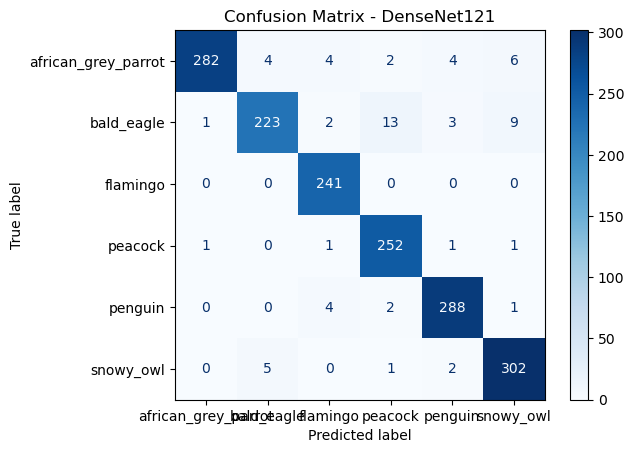


Classification Report - DenseNet121
                     precision    recall  f1-score   support

african_grey_parrot       0.99      0.93      0.96       302
         bald_eagle       0.96      0.89      0.92       251
           flamingo       0.96      1.00      0.98       241
            peacock       0.93      0.98      0.96       256
            penguin       0.97      0.98      0.97       295
          snowy_owl       0.95      0.97      0.96       310

           accuracy                           0.96      1655
          macro avg       0.96      0.96      0.96      1655
       weighted avg       0.96      0.96      0.96      1655

Found 1655 images belonging to 6 classes.
 1/52 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step

D:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step


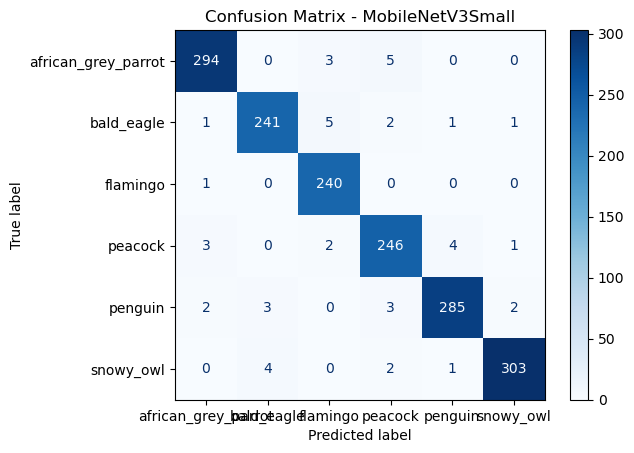


Classification Report - MobileNetV3Small
                     precision    recall  f1-score   support

african_grey_parrot       0.98      0.97      0.98       302
         bald_eagle       0.97      0.96      0.97       251
           flamingo       0.96      1.00      0.98       241
            peacock       0.95      0.96      0.96       256
            penguin       0.98      0.97      0.97       295
          snowy_owl       0.99      0.98      0.98       310

           accuracy                           0.97      1655
          macro avg       0.97      0.97      0.97      1655
       weighted avg       0.97      0.97      0.97      1655



In [26]:
# For ResNet50
evaluate_model(resnet_model, "ResNet50", resnet_preprocess, test_dir)

# For DenseNet121
evaluate_model(densenet_model, "DenseNet121", densenet_preprocess, test_dir)

# For MobileNetV3Small
evaluate_model(mobilenet_model, "MobileNetV3Small", mobilenet_preprocess, test_dir)

## 15. Parameter Count (Model Size)

In [27]:
def get_model_params(model, model_name):
    total_params = model.count_params()
    print(f"{model_name} - Total Parameters: {total_params:,}")
    return total_params

resnet_params = get_model_params(resnet_model, "ResNet50")
densenet_params = get_model_params(densenet_model, "DenseNet121")
mobilenet_params = get_model_params(mobilenet_model, "MobileNetV3Small")

ResNet50 - Total Parameters: 23,600,006
DenseNet121 - Total Parameters: 7,043,654
MobileNetV3Small - Total Parameters: 942,582


## 16. Final Summary Table for All Models

In [28]:
# Add parameter counts to the summary
summary = {
    'Model': ['ResNet50', 'DenseNet121', 'MobileNetV3Small'],
    'Accuracy': [resnet_acc, densenet_acc, mobilenet_acc],
    'mAP': [resnet_map, densenet_map, mobilenet_map],
    'Training Time (s)': [resnet_time, densenet_time, mobilenet_time],
    'Parameters': [resnet_params, densenet_params, mobilenet_params]
}

import pandas as pd
df_summary = pd.DataFrame(summary)
print(df_summary)

              Model  Accuracy       mAP  Training Time (s)  Parameters
0          ResNet50  0.937764  0.987472       22272.782253    23600006
1       DenseNet121  0.959517  0.993256       26159.534108     7043654
2  MobileNetV3Small  0.972205  0.994405        2018.952417      942582


## 17. Conclusion Block

In [29]:
best_model = df_summary.sort_values(by=['mAP', 'Accuracy'], ascending=False).iloc[0]
print("🏆 Best Model Recommendation:")
print(f"Model: {best_model['Model']}")
print(f"Accuracy: {best_model['Accuracy']:.4f}")
print(f"mAP: {best_model['mAP']:.4f}")
print(f"Parameters: {best_model['Parameters']:,}")
print(f"Training Time: {best_model['Training Time (s)']:.2f} seconds")

🏆 Best Model Recommendation:
Model: MobileNetV3Small
Accuracy: 0.9722
mAP: 0.9944
Parameters: 942,582
Training Time: 2018.95 seconds
